## Project Predictive Analytics: New York City Taxi Ride Duration Prediction

## **Marks: 40**
---------------

## **Context**
---------------

New York City taxi rides form the core of the traffic in the city of New York. The many rides taken every day by New Yorkers in the busy city can give us a great idea of traffic times, road blockages, and so on. A typical taxi company faces a common problem of efficiently assigning the cabs to passengers so that the service is hassle-free. One of the main issues is predicting the duration of the current ride so it can predict when the cab will be free for the next trip. Here the data set contains various information regarding the taxi trips, its duration in New York City. We will apply different techniques here to get insights into the data and determine how different variables are dependent on the Trip Duration.

-----------------
## **Objective**
-----------------

- To Build a predictive model, for predicting the duration for the taxi ride. 
- Use Automated feature engineering to create new features

-----------------
## **Dataset**
-----------------

The ``trips`` table has the following fields
* ``id`` which uniquely identifies the trip
* ``vendor_id`` is the taxi cab company - in our case study we have data from three different cab companies
* ``pickup_datetime`` the time stamp for pickup
* ``dropoff_datetime`` the time stamp for drop-off
* ``passenger_count`` the number of passengers for the trip
* ``trip_distance`` total distance of the trip in miles 
* ``pickup_longitude`` the longitude for pickup
* ``pickup_latitude`` the latitude for pickup
* ``dropoff_longitude``the longitude of dropoff 
* ``dropoff_latitude`` the latitude of dropoff
* ``payment_type`` a numeric code signifying how the passenger paid for the trip. 1= Credit card 2= Cash 3= No charge 4= Dispute 5= Unknown 6= Voided
* ``trip_duration`` this is the duration we would like to predict using other fields 
* ``pickup_neighborhood`` a one or two letter id of the neighborhood where the trip started
* ``dropoff_neighborhood`` a one or two letter id of the neighborhood where the trip ended



### We will do the following steps:
  * Install the dependencies
  * Load the data as pandas dataframe
  * Perform EDA on the dataset
  * Build features with Deep Feature Synthesis using the [featuretools](https://featuretools.com) package. We will start with simple features and incrementally improve the feature definitions and examine the accuracy of the system

#### Uncomment the code given below, and run the line of code to install featuretools library

In [ ]:
# Uncomment the code given below, and run the line of code to install featuretools library

#!pip install featuretools==0.27.0

### Note: If !pip install featuretools doesn't work, please install using the anaconda prompt by typing the following command in anaconda prompt
      conda install -c conda-forge featuretools==0.27.0

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Feataurestools for feature engineering
import featuretools as ft

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Importing gradient boosting regressor, to make prediction
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

#importing primitives
from featuretools.primitives import (Minute, Hour, Day, Month,
                                     Weekday, IsWeekend, Count, Sum, Mean, Median, Std, Min, Max)

print(ft.__version__)
%load_ext autoreload
%autoreload 2

0.27.0


In [2]:
# set global random seed
np.random.seed(40)

# To load the dataset
def load_nyc_taxi_data():
    trips = pd.read_csv('trips.csv',
                        parse_dates=["pickup_datetime","dropoff_datetime"],
                        dtype={'vendor_id':"category",'passenger_count':'int64'},
                        encoding='utf-8')
    trips["payment_type"] = trips["payment_type"].apply(str)
    trips = trips.dropna(axis=0, how='any', subset=['trip_duration'])

    pickup_neighborhoods = pd.read_csv("pickup_neighborhoods.csv", encoding='utf-8')
    dropoff_neighborhoods = pd.read_csv("dropoff_neighborhoods.csv", encoding='utf-8')

    return trips, pickup_neighborhoods, dropoff_neighborhoods

### To preview first five rows. 
def preview(df, n=5):
    """return n rows that have fewest number of nulls"""
    order = df.isnull().sum(axis=1).sort_values().head(n).index
    return df.loc[order]



#to compute features using automated feature engineering. 
def compute_features(features, cutoff_time):
    # shuffle so we don't see encoded features in the front or backs

    np.random.shuffle(features)
    feature_matrix = ft.calculate_feature_matrix(features,
                                                 cutoff_time=cutoff_time,
                                                 approximate='36d',
                                                 verbose=True)
    print("Finishing computing...")
    feature_matrix, features = ft.encode_features(feature_matrix, features,
                                                  to_encode=["pickup_neighborhood", "dropoff_neighborhood"],
                                                  include_unknown=False)
    return feature_matrix


#to generate train and test dataset
def get_train_test_fm(feature_matrix, percentage):
    nrows = feature_matrix.shape[0]
    head = int(nrows * percentage)
    tail = nrows-head
    X_train = feature_matrix.head(head)
    y_train = X_train['trip_duration']
    X_train = X_train.drop(['trip_duration'], axis=1)
    imp = SimpleImputer()
    X_train = imp.fit_transform(X_train)
    X_test = feature_matrix.tail(tail)
    y_test = X_test['trip_duration']
    X_test = X_test.drop(['trip_duration'], axis=1)
    X_test = imp.transform(X_test)

    return (X_train, y_train, X_test,y_test)



#to see the feature importance of variables in the final model
def feature_importances(model, feature_names, n=5):
    importances = model.feature_importances_
    zipped = sorted(zip(feature_names, importances), key=lambda x: -x[1])
    for i, f in enumerate(zipped[:n]):
        print("%d: Feature: %s, %.3f" % (i+1, f[0], f[1]))

### Load the Datasets

In [3]:
trips, pickup_neighborhoods, dropoff_neighborhoods = load_nyc_taxi_data()
preview(trips, 10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,0,2,2016-01-01 00:00:19,2016-01-01 00:06:31,3,1.32,-73.961258,40.796200,-73.950050,40.787312,2,372.0,AH,C
649598,679634,1,2016-04-30 11:45:59,2016-04-30 11:47:47,1,0.50,-73.994919,40.755226,-74.000351,40.747917,1,108.0,D,AG
649599,679635,2,2016-04-30 11:46:04,2016-04-30 11:47:41,2,0.33,-73.978935,40.777172,-73.981888,40.773136,2,97.0,AV,AV
649600,679636,2,2016-04-30 11:46:39,2016-04-30 11:58:02,1,1.78,-73.998207,40.745201,-73.990265,40.729023,2,683.0,AP,H
649601,679637,2,2016-04-30 11:46:44,2016-04-30 11:55:42,1,1.40,-73.987129,40.739429,-74.007370,40.743511,2,538.0,R,Q
649602,679638,2,2016-04-30 11:47:30,2016-04-30 11:54:00,1,1.12,-73.942375,40.790768,-73.952095,40.777145,2,390.0,J,AM
649603,679639,1,2016-04-30 11:47:38,2016-04-30 11:57:22,2,1.90,-73.960800,40.769920,-73.978966,40.785698,1,584.0,K,I
649604,679640,1,2016-04-30 11:47:49,2016-04-30 12:01:05,1,4.30,-74.013885,40.709515,-73.987213,40.722343,2,796.0,AU,AC
649605,679641,1,2016-04-30 11:48:17,2016-04-30 12:01:02,1,2.90,-73.975426,40.757584,-73.999016,40.722027,1,765.0,A,X
649606,679642,1,2016-04-30 11:49:44,2016-04-30 12:00:03,1,1.30,-73.989815,40.750454,-74.000473,40.762352,2,619.0,D,P


### Display first five rows

In [4]:
trips.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,0,2,2016-01-01 00:00:19,2016-01-01 00:06:31,3,1.32,-73.961258,40.796200,-73.950050,40.787312,2,372.0,AH,C
1,1,2,2016-01-01 00:01:45,2016-01-01 00:27:38,1,13.70,-73.956169,40.707756,-73.939949,40.839558,1,1553.0,Z,S
2,2,1,2016-01-01 00:01:47,2016-01-01 00:21:51,2,5.30,-73.993103,40.752632,-73.953903,40.816540,2,1204.0,D,AL
3,3,2,2016-01-01 00:01:48,2016-01-01 00:16:06,1,7.19,-73.983009,40.731419,-73.930969,40.808460,2,858.0,AT,J
4,4,1,2016-01-01 00:02:49,2016-01-01 00:20:45,2,2.90,-74.004631,40.747234,-73.976395,40.777237,1,1076.0,AG,AV


### Display info of the dataset

In [5]:
#checking the info of the dataset
trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 974409 entries, 0 to 974408
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    974409 non-null  int64         
 1   vendor_id             974409 non-null  category      
 2   pickup_datetime       974409 non-null  datetime64[ns]
 3   dropoff_datetime      974409 non-null  datetime64[ns]
 4   passenger_count       974409 non-null  int64         
 5   trip_distance         974409 non-null  float64       
 6   pickup_longitude      974409 non-null  float64       
 7   pickup_latitude       974409 non-null  float64       
 8   dropoff_longitude     974409 non-null  float64       
 9   dropoff_latitude      974409 non-null  float64       
 10  payment_type          974409 non-null  object        
 11  trip_duration         974409 non-null  float64       
 12  pickup_neighborhood   974409 non-null  object        
 13 

- There are 974409 non null values in the dataset

### Check the number of unique values in the dataset.

In [6]:
# Check the uniques values in each columns
trips.nunique()

id                      974409
vendor_id                    2
pickup_datetime         939015
dropoff_datetime        938873
passenger_count              8
trip_distance             2503
pickup_longitude         20222
pickup_latitude          40692
dropoff_longitude        26127
dropoff_latitude         50077
payment_type                 4
trip_duration             3607
pickup_neighborhood         49
dropoff_neighborhood        49
dtype: int64

- vendor_id has only 2 unique values, implies there are only 2 major taxi vendors are there. 
- Passenger count has 8 unique values and payment type have 4. 
- There are 49 neighborhood in the dataset, from where either a pickup or dropoff is happening. 

### Question 1 : Check summary statistics of the dataset (1 Mark)

In [7]:
#chekcing the descriptive stats of the data

#Remove _________ and complete the code

trips.describe().T

,count,mean,std,min,25%,50%,75%,max
id,974409.0,509622.259282,294491.646773,0.000000,254521.000000,509310.000000,764743.000000,1.020002e+06
passenger_count,974409.0,1.664010,1.314975,0.000000,1.000000,1.000000,2.000000,9.000000e+00
trip_distance,974409.0,2.734356,3.307038,0.000000,1.000000,1.640000,2.990000,5.028000e+02
pickup_longitude,974409.0,-73.973275,0.035702,-74.029846,-73.991058,-73.981178,-73.966888,-7.377051e+01
pickup_latitude,974409.0,40.752475,0.026668,40.630268,40.739689,40.755390,40.768929,4.084991e+01
dropoff_longitude,974409.0,-73.972825,0.031348,-74.029945,-73.990356,-73.979156,-73.962769,-7.377002e+01
dropoff_latitude,974409.0,40.753046,0.029151,40.630009,40.738792,40.755650,40.770454,4.085000e+01
trip_duration,974409.0,797.702753,576.802176,0.000000,389.000000,646.000000,1040.000000,3.606000e+03


**Write your answers here:**
- The mean passenger count is 1.66, that means that the max value (9) is an outlier
- the average trip distance is 2.73
- the mean trip_duration is 797

#### Checking for the rows for which trip_distance is 0

In [8]:
#Chekcing the rows where trip distance is 0
trips[trips['trip_distance']==0]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
852,880,1,2016-01-01 02:15:56,2016-01-01 02:16:17,1,0.0,-74.002586,40.750298,-74.002861,40.750446,2,21.0,AG,AG
1079,1116,1,2016-01-01 03:01:10,2016-01-01 03:03:26,1,0.0,-73.987831,40.728558,-73.988747,40.727280,3,136.0,H,H
1408,1455,2,2016-01-01 04:09:43,2016-01-01 04:10:48,1,0.0,-73.985893,40.763649,-73.985741,40.763672,2,65.0,AR,AR
1440,1488,1,2016-01-01 04:16:54,2016-01-01 04:16:57,1,0.0,-74.014198,40.709988,-74.014198,40.709988,3,3.0,AU,AU
1510,1558,1,2016-01-01 04:36:03,2016-01-01 04:36:16,1,0.0,-73.952507,40.817329,-73.952499,40.817322,2,13.0,AL,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972967,1018490,1,2016-06-30 19:09:44,2016-06-30 19:22:21,1,0.0,-73.945480,40.751400,-73.945496,40.751549,2,757.0,AN,AN
973384,1018928,2,2016-06-30 20:35:08,2016-06-30 20:35:10,1,0.0,-73.983864,40.693813,-73.983910,40.693817,1,2.0,AS,AS
973555,1019105,2,2016-06-30 21:13:50,2016-06-30 21:14:05,1,0.0,-74.008789,40.708740,-74.008659,40.708858,1,15.0,AU,AU
973607,1019159,2,2016-06-30 21:24:23,2016-06-30 21:37:40,1,0.0,-73.974510,40.778297,-73.977272,40.754047,1,797.0,I,AD


- We can observe that, where trip distance is 0 trip duration is not 0, hence we can replace those values. 
- There are 3807 such rows

#### Replacing the 0 values with median of the trip distance

In [9]:
trips['trip_distance']=trips['trip_distance'].replace(0,trips['trip_distance'].median())

In [10]:
trips[trips['trip_distance']==0].count()

id                      0
vendor_id               0
pickup_datetime         0
dropoff_datetime        0
passenger_count         0
trip_distance           0
pickup_longitude        0
pickup_latitude         0
dropoff_longitude       0
dropoff_latitude        0
payment_type            0
trip_duration           0
pickup_neighborhood     0
dropoff_neighborhood    0
dtype: int64

#### Checking for the rows for which trip_duration is 0

In [11]:
trips[trips['trip_duration']==0].head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
44446,46325,1,2016-01-10 00:48:55,2016-01-10 00:48:55,1,1.20,-73.968842,40.766972,-73.968842,40.766972,3,0.0,AK,AK
121544,126869,2,2016-01-26 00:07:47,2016-01-26 00:07:47,6,4.35,-73.986694,40.739815,-73.956139,40.732872,1,0.0,R,Z
142202,148598,1,2016-01-30 00:00:29,2016-01-30 00:00:29,1,1.64,-73.989578,40.743877,-73.989578,40.743877,2,0.0,AO,AO
172653,180414,1,2016-02-04 19:23:45,2016-02-04 19:23:45,1,0.40,-73.990868,40.751106,-73.990868,40.751106,2,0.0,D,D
173013,180795,1,2016-02-04 20:23:10,2016-02-04 20:23:10,1,0.80,-73.977661,40.752968,-73.977661,40.752968,2,0.0,AD,AD


- We can observe that, where trip distance is 0 trip duration is not 0, hence we can replace those values. 

In [12]:
trips['trip_duration']=trips['trip_duration'].replace(0,trips['trip_duration'].median())

In [13]:
trips[trips['trip_duration']==0].count()

id                      0
vendor_id               0
pickup_datetime         0
dropoff_datetime        0
passenger_count         0
trip_distance           0
pickup_longitude        0
pickup_latitude         0
dropoff_longitude       0
dropoff_latitude        0
payment_type            0
trip_duration           0
pickup_neighborhood     0
dropoff_neighborhood    0
dtype: int64

### Question 2: Univariate Analysis

### Question 2.1: Build histogram for numerical columns (1 Marks)

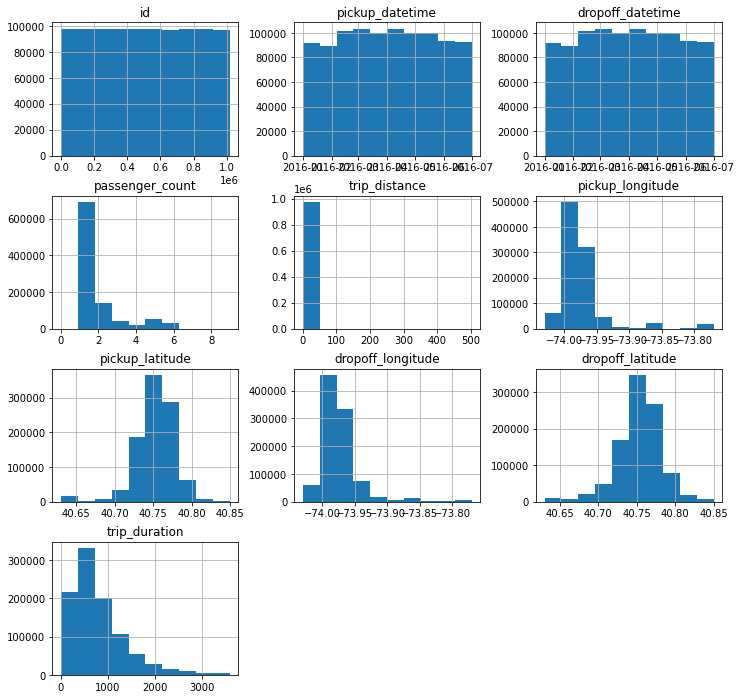

In [19]:
#Remove _________ and complete the code
trips.hist(figsize=(12,12))
plt.show()

**Write your answers here:**
- pickup_latitude and dropoff_latitude are approximately normal distributed
- trip_distance probably have a few outliers
- dropoff_longitude, pickup_longitude and passenger_count and right skewed
- trip duration is also very right skewed

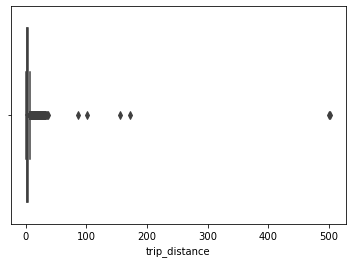

In [21]:
sns.boxplot(x=trips['trip_distance'])
plt.show()

- We can see there is an extreme outlier in the dataset, we drop investigate it further

In [22]:
trips[trips['trip_distance']>100]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
171143,178815,1,2016-02-04 14:05:10,2016-02-04 14:56:37,1,156.2,-73.979149,40.765499,-73.782806,40.644009,1,3087.0,AR,G
248346,259490,1,2016-02-18 09:48:06,2016-02-18 09:50:27,1,501.4,-73.980087,40.782185,-73.981468,40.778519,2,141.0,I,AV
525084,548884,1,2016-04-07 21:19:03,2016-04-07 22:03:17,3,172.3,-73.783340,40.644176,-73.936028,40.737762,2,2654.0,G,AN
530340,554389,1,2016-04-08 19:19:32,2016-04-08 19:41:33,2,502.8,-73.995461,40.724884,-73.986099,40.762108,1,1321.0,X,AA
828650,867217,1,2016-06-02 21:30:17,2016-06-02 21:36:47,2,101.0,-73.961586,40.800968,-73.950165,40.802193,2,390.0,AH,J


- We can observe that, there are 2 observation>500, and there is a huge gap in the trip duration for them.
- Covering 501.4 distance in 141 sec, is not possible, it is better we can clip these values to 50. 

#### Clipping the outliers of trip distance to 50

In [23]:
trips['trip_distance']=trips['trip_distance'].clip(trips['trip_distance'].min(),50)

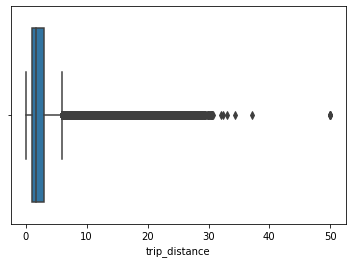

In [25]:
sns.boxplot(x=trips['trip_distance'])
plt.show()

### Question 2.2 Plotting countplot for Passenger_count (1 Marks)

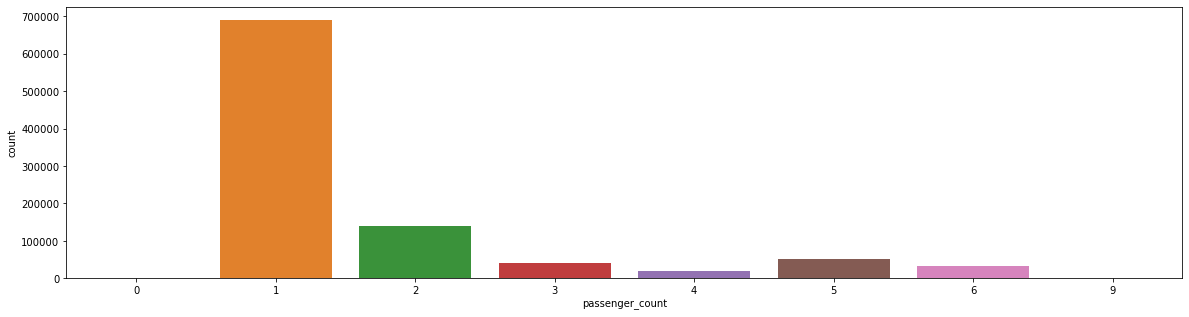

In [26]:
#Remove _________ and complete the code

import seaborn as sns
plt.figure(figsize=(20,5))
sns.countplot(x='passenger_count', data=trips)
plt.show()

In [27]:
trips.passenger_count.value_counts(normalize=True)

1    0.709334
2    0.143419
5    0.053409
3    0.041140
6    0.033334
4    0.019338
0    0.000025
9    0.000002
Name: passenger_count, dtype: float64

**Write your answers here:**
- The distribution of the passenger count is very right skewed, there are many trips with 1 or 2 passengers (84%) and a very amount of trips with more passengers then that. 


### Question 2.3 Plotting countplot for pickup_neighborhood and dropoff_neighborhood (2 Marks)

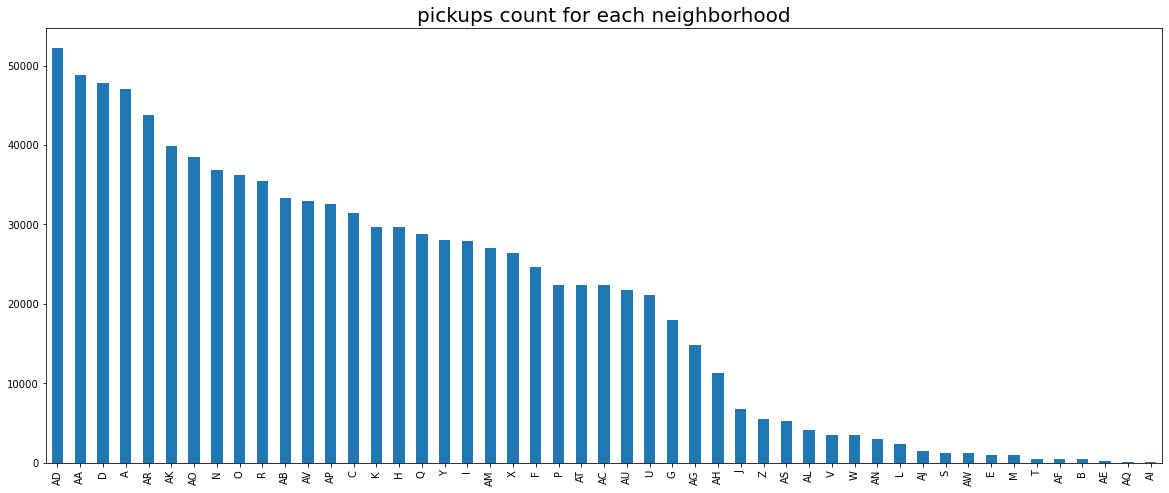

In [36]:
#Remove _________ and complete the code
trips.pickup_neighborhood.value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(20,8))
plt.title('pickups count for each neighborhood', size=20)
plt.show()

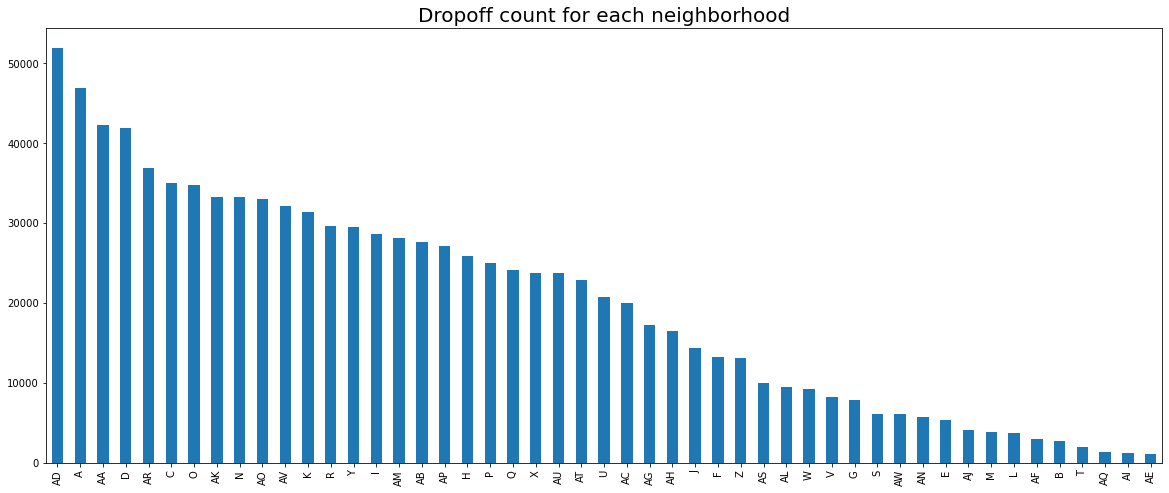

In [37]:
#Remove _________ and complete the code

trips.dropoff_neighborhood.value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(20,8))
plt.title('Dropoff count for each neighborhood', size=20)
plt.show()

**Write your answers here:**
- most of pickups and dropoffs are in the areas AD, A, AA and D
- areas like AE, AJ and AQ have very few trips

In [38]:
pickup_neighborhoods.head()

,neighborhood_id,latitude,longitude
0,AH,40.804349,-73.961716
1,Z,40.715828,-73.954298
2,D,40.750179,-73.992557
3,AT,40.729670,-73.981693
4,AG,40.749843,-74.003458


### Bivariate analysis

#### Plot a scatter plot for trip distance and trip duration

<AxesSubplot:xlabel='trip_distance', ylabel='trip_duration'>

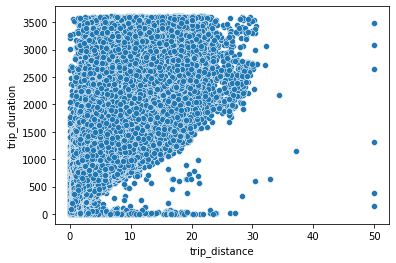

In [40]:
sns.scatterplot(x=trips['trip_distance'],y=trips['trip_duration'])

- There is some positive correlation between trip_distance and trip_duration.

<AxesSubplot:xlabel='passenger_count', ylabel='count'>

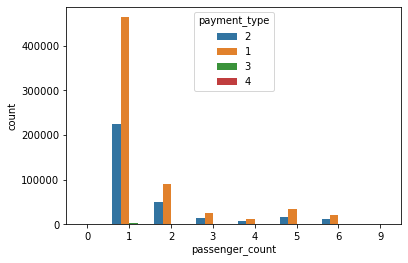

In [41]:
sns.countplot(x=trips['passenger_count'],hue=trips['payment_type'])

- There is no such specific pattern can be observed.

### Step 2: Prepare the Data

Lets create entities and relationships. The three entities in this data are 
* trips 
* pickup_neighborhoods
* dropoff_neighborhoods

This data has the following relationships
* pickup_neighborhoods --> trips (one neighborhood can have multiple trips that start in it. This means pickup_neighborhoods is the ``parent_entity`` and trips is the child entity)
* dropoff_neighborhoods --> trips (one neighborhood can have multiple trips that end in it. This means dropoff_neighborhoods is the ``parent_entity`` and trips is the child entity)

In <a <href="https://www.featuretools.com/"><featuretools (automated feature engineering software package)/></a>, we specify the list of entities and relationships as follows: 


### Question 3: Define entities and relationships for the Deep Feature Synthesis (2 Marks)

In [42]:
#Remove _________ and complete the codeV

entities = {'trips':(trips, 'id', 'pickup_datetime'), 
            'pickup_neighborhoods':(pickup_neighborhoods, 'neighborhood_id'),
            'dropoff_neighborhoods':(dropoff_neighborhoods, 'neighborhood_id')}

#Remove _________ and complete the code
relationships = [('pickup_neighborhoods','neighborhood_id', 'trips', 'pickup_neighborhood'),
                 ('dropoff_neighborhoods','neighborhood_id', 'trips', 'dropoff_neighborhood')]

Next, we specify the cutoff time for each instance of the target_entity, in this case ``trips``.This timestamp represents the last time data can be used for calculating features by DFS. In this scenario, that would be the pickup time because we would like to make the duration prediction using data before the trip starts. 

For the purposes of the case study, we choose to only select trips that started after January 12th, 2016. 

In [43]:
cutoff_time = trips[['id', 'pickup_datetime']]
cutoff_time = cutoff_time[cutoff_time['pickup_datetime'] > "2016-01-12"]
preview(cutoff_time, 10)

,id,pickup_datetime
54031,56311,2016-01-12 00:00:25
667608,698423,2016-05-03 17:59:59
667609,698424,2016-05-03 18:00:52
667610,698425,2016-05-03 18:01:06
667611,698426,2016-05-03 18:01:11
667612,698427,2016-05-03 18:01:12
667613,698428,2016-05-03 18:01:12
667614,698429,2016-05-03 18:01:24
667615,698430,2016-05-03 18:01:36
667616,698431,2016-05-03 18:01:39


### Step 3: Create baseline features using Deep Feature Synthesis

Instead of manually creating features, such as "month of pickup datetime", we can let DFS come up with them automatically. It does this by 
* interpreting the variable types of the columns e.g categorical, numeric and others 
* matching the columns to the primitives that can be applied to their variable types
* creating features based on these matches

**Create transform features using transform primitives**

As we described in the video, features fall into two major categories, ``transform`` and ``aggregate``. In featureools, we can create transform features by specifying ``transform`` primitives. Below we specify a ``transform`` primitive called ``weekend`` and here is what it does:

* It can be applied to any ``datetime`` column in the data. 
* For each entry in the column, it assess if it is a ``weekend`` and returns a boolean. 

In this specific data, there are two ``datetime`` columns ``pickup_datetime`` and ``dropoff_datetime``. The tool automatically creates features using the primitive and these two columns as shown below. 

### Question 4: Creating a baseline model with only 1 transform primitive (10 Marks)

**Question: 4.1 Define transform primitive for weekend and define features using dfs?** 

In [44]:
#Remove _________ and complete the code
trans_primitives = [IsWeekend]

#Remove _________ and complete the code
features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

*If you're interested about parameters to DFS such as `ignore_variables`, you can learn more about these parameters [here](https://docs.featuretools.com/generated/featuretools.dfs.html#featuretools.dfs)*
<p>Here are the features created.</p>

In [45]:
print ("Number of features: %d" % len(features))
features

Number of features: 13


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]


Now let's compute the features. 

**Question: 4.2 Compute features and define feature matrix**

In [46]:
def compute_features(features, cutoff_time):
    # shuffle so we don't see encoded features in the front or backs

    np.random.shuffle(features)
    feature_matrix = ft.calculate_feature_matrix(features,
                                                 cutoff_time=cutoff_time,
                                                 approximate='36d',
                                                 verbose=True,entities=entities, relationships=relationships)
    print("Finishing computing...")
    feature_matrix, features = ft.encode_features(feature_matrix, features,
                                                  to_encode=["pickup_neighborhood", "dropoff_neighborhood"],
                                                  include_unknown=False)
    return feature_matrix

In [47]:
#Remove _________ and complete the code
feature_matrix1 = compute_features(features, cutoff_time)

Elapsed: 00:03 | Progress: 100%|████████████████████████████████████████████████
Finishing computing...


In [48]:
preview(feature_matrix1, 5)

,dropoff_neighborhood = AD,dropoff_neighborhood = A,dropoff_neighborhood = AA,dropoff_neighborhood = D,dropoff_neighborhood = AR,dropoff_neighborhood = C,dropoff_neighborhood = O,dropoff_neighborhood = N,dropoff_neighborhood = AK,dropoff_neighborhood = AO,...,pickup_neighborhood = A,pickup_neighborhood = AR,pickup_neighborhood = AK,pickup_neighborhood = AO,pickup_neighborhood = N,pickup_neighborhood = O,pickup_neighborhood = R,dropoff_neighborhoods.latitude,dropoff_neighborhoods.longitude,IS_WEEKEND(pickup_datetime)
id,,,,,,,,,,,,,,,,,,,,,
56311,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,40.721435,-73.998366,False
698423,True,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,40.752186,-73.976515,False
698424,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,40.775299,-73.960551,False
698425,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,40.793597,-73.969822,False
698426,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,40.766809,-73.956886,False


In [49]:
feature_matrix1.shape

(920378, 31)

### Build the Model

To build a model, we
* Separate the data into a portion for ``training`` (75% in this case) and a portion for ``testing`` 
* Get the log of the trip duration so that a more linear relationship can be found.
* Train a model using a ``Linear Regression, Decision Tree and Random Forest model``

#### Transforming the duration variable on sqrt and log

(array([  4566.,  35831., 163872., 249551., 225381., 149544.,  80472.,
         38481.,  18054.,   8657.]),
 array([ 1.        ,  6.90499792, 12.80999584, 18.71499376, 24.61999167,
        30.52498959, 36.42998751, 42.33498543, 48.23998335, 54.14498127,
        60.04997918]),
 <BarContainer object of 10 artists>)

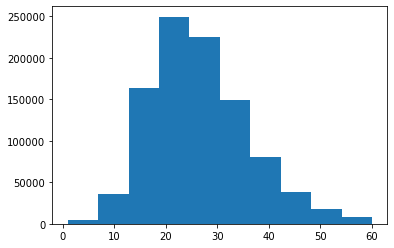

In [50]:
plt.hist(np.sqrt(trips['trip_duration']))

(array([1.81000e+02, 5.97000e+02, 7.44000e+02, 1.43900e+03, 2.86700e+03,
        2.00260e+04, 1.35785e+05, 3.69738e+05, 3.50815e+05, 9.22170e+04]),
 array([0.        , 0.81903544, 1.63807088, 2.45710632, 3.27614176,
        4.0951772 , 4.91421264, 5.73324808, 6.55228352, 7.37131896,
        8.1903544 ]),
 <BarContainer object of 10 artists>)

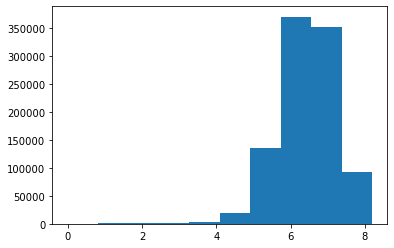

In [51]:
plt.hist(np.log(trips['trip_duration']))

- We can clearly see that the sqrt transformation is giving nearly normal distribution, there for we can choose the sqrt transformation on the dependent(trip_duration) variable.

### Splitting the data into train and test

In [52]:
# separates the whole feature matrix into train data feature matrix, 
# train data labels, and test data feature matrix 
X_train, y_train, X_test, y_test = get_train_test_fm(feature_matrix1,.75)
y_train = np.sqrt(y_train)
y_test = np.sqrt(y_test)

### Defining function for to check the performance of the model. 

In [53]:
#RMSE
def rmse(predictions, targets):
    return np.sqrt(((targets - predictions) ** 2).mean())

# MAE
def mae(predictions, targets):
    return np.mean(np.abs((targets - predictions)))


# Model Performance on test and train data
def model_pref(model, x_train, x_test, y_train,y_test):

    # Insample Prediction
    y_pred_train = model.predict(x_train)
    y_observed_train = y_train

    # Prediction on test data
    y_pred_test = model.predict(x_test)
    y_observed_test = y_test

    print(
        pd.DataFrame(
            {
                "Data": ["Train", "Test"],
                'RSquared':
                    [r2_score(y_observed_train,y_pred_train),
                    r2_score(y_observed_test,y_pred_test )
                    ],
                "RMSE": [
                    rmse(y_pred_train, y_observed_train),
                    rmse(y_pred_test, y_observed_test),
                ],
                "MAE": [
                    mae(y_pred_train, y_observed_train),
                    mae(y_pred_test, y_observed_test),
                ],
            }
        )
    )

#### Question 4.3 Build Linear regression using only weekend transform primitive

In [54]:
#Remove _________ and complete the code

#defining the model

lr1=LinearRegression()

#fitting the model
lr1.fit(X_train, y_train)


LinearRegression()

#### Check the performance of the model

In [55]:
#Remove _________ and complete the code
model_pref(lr1, X_train, X_test, y_train, y_test)  

    Data  RSquared      RMSE       MAE
0  Train  0.576106  6.132169  4.736641
1   Test  0.555831  6.558806  5.024874


**Write your answers here:**
- model is giving only 0.55 in Rsquared, with 6.55 of RMSE and ~ 5 of MAE
- the model is slightly overfitting

#### Question 4.4 Building decision tree using only weekend transform primitive

In [56]:
#Remove _________ and complete the code

#define the model
dt=DecisionTreeRegressor()

#fit the model

dt.fit(X_train, y_train)

DecisionTreeRegressor()

#### Check the performance of the model

In [57]:
#Remove _________ and complete the code
model_pref(dt, X_train, X_test, y_train, y_test)  

    Data  RSquared      RMSE       MAE
0  Train  0.917069  2.712331  1.518055
1   Test  0.597426  6.244153  4.638653


**Write your answers here:**
- the model is very overfitted, with high train rsquared anndo low test rsquared


#### Question 4.5 Building Pruned decision tree using only weekend transform primitive

In [58]:
#Remove _________ and complete the code
#define the model

#use max_depth=7
dt_pruned=DecisionTreeRegressor(max_depth=7)

#fit the model
dt_pruned.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=7)

#### Check the performance of the model

In [59]:
#Remove _________ and complete the code
model_pref(dt_pruned, X_train, X_test, y_train, y_test)  

    Data  RSquared      RMSE       MAE
0  Train  0.733766  4.859783  3.708634
1   Test  0.704190  5.352503  4.049448


**Write your answers here:**
- the pruned tree is performing better the not pruned tree and the linear regression model


#### Question 4.6 Building Random Forest using only weekend transform primitive

In [60]:
#Remove _________ and complete the code

#define the model

#using (n_estimators=60,max_depth=7)

rf=RandomForestRegressor(n_estimators=60,max_depth=7)

In [61]:
#fit the model

#Remove _________ and complete the code
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, n_estimators=60)

#### Check the performance of the model

In [62]:
#Remove _________ and complete the code

model_pref(rf, X_train, X_test, y_train, y_test)

    Data  RSquared      RMSE       MAE
0  Train  0.738265  4.818549  3.676261
1   Test  0.708235  5.315778  4.019578


**Write your answers here:**
- random forest is performing just like the pruned tree, not worth because of the computational cost

### Step 4: Adding more Transform Primitives and creating new model

* Add ``Minute``, ``Hour``, ``Month``, ``Weekday`` , etc primitives
* All these transform primitives apply to ``datetime`` columns

### Question 5: Create models with more transform primitives (10 Marks)

**Question 5.1 Define more transform primitives and define features using dfs?**

In [63]:
#Remove _________ and complete the code
trans_primitives = [Minute, Hour, Day, Month, Weekday, IsWeekend]

#Remove _________ and complete the code
features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [64]:
print ("Number of features: %d" % len(features))
features

Number of features: 23


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]

Now let's compute the features. 

**Question: 5.2 Compute features and define feature matrix**

In [65]:
#Remove _________ and complete the code
feature_matrix2 = compute_features(features, cutoff_time)

Elapsed: 00:04 | Progress: 100%|████████████████████████████████████████████████
Finishing computing...


In [66]:
feature_matrix2.shape

(920378, 41)

In [67]:
feature_matrix2.head()

,WEEKDAY(pickup_datetime),trip_duration,MINUTE(pickup_datetime),DAY(dropoff_datetime),payment_type,IS_WEEKEND(dropoff_datetime),pickup_neighborhoods.latitude,DAY(pickup_datetime),dropoff_neighborhood = AD,dropoff_neighborhood = A,...,HOUR(dropoff_datetime),dropoff_neighborhoods.latitude,vendor_id,MINUTE(dropoff_datetime),MONTH(dropoff_datetime),dropoff_neighborhoods.longitude,trip_distance,MONTH(pickup_datetime),WEEKDAY(dropoff_datetime),HOUR(pickup_datetime)
id,,,,,,,,,,,,,,,,,,,,,
56311,1,645.0,0,12,1,False,40.720245,12,False,False,...,0,40.721435,2,11,1,-73.998366,1.61,1,1,0
56312,1,1270.0,2,12,2,False,40.646194,12,False,False,...,0,40.715828,2,23,1,-73.954298,16.15,1,1,0
56313,1,207.0,2,12,1,False,40.818445,12,False,False,...,0,40.818445,1,5,1,-73.948046,0.80,1,1,0
56314,1,214.0,2,12,2,False,40.729652,12,False,False,...,0,40.742531,2,6,1,-73.977943,1.33,1,1,0
56315,1,570.0,3,12,1,False,40.793597,12,False,False,...,0,40.818445,2,13,1,-73.948046,2.35,1,1,0


### Build the new models more transform features

In [68]:
# separates the whole feature matrix into train data feature matrix,
# train data labels, and test data feature matrix 
X_train2, y_train2, X_test2, y_test2 = get_train_test_fm(feature_matrix2,.75)
y_train2 = np.sqrt(y_train2)
y_test2 = np.sqrt(y_test2)

#### Question 5.3 Building Linear regression using more transform primitive

In [72]:
#Remove _________ and complete the code

#defining the model

lr2=LinearRegression()

#fitting the model
lr2.fit(X_train2, y_train2)


LinearRegression()

#### Check the performance of the model

In [73]:
#Remove _________ and complete the code
model_pref(lr2, X_train2, X_test2, y_train2, y_test2)  

    Data  RSquared      RMSE       MAE
0  Train  0.623501  5.779195  4.273127
1   Test  0.623651  6.037346  4.537582


**Write your answers here:**
- model is giving 0.62 of RSquared, with 6.03 RMSE and ~ 4.5 MAE
- slightly better performance compared with lr with less features

#### Question 5.4 Building Decision tree using more transform primitive

In [74]:
#Remove _________ and complete the code

#define the model
dt2=DecisionTreeRegressor()

#fit the model

dt2.fit(X_train2, y_train2)

DecisionTreeRegressor()

#### Check the performance of the model

In [75]:
#Remove _________ and complete the code
model_pref(dt2, X_train2, X_test2, y_train2, y_test2)  

    Data  RSquared      RMSE       MAE
0  Train  1.000000  0.001479  0.000004
1   Test  0.713607  5.266615  3.789094


**Write your answers here:**
- The model is extremely overfitted, with Rsquared equal to 1 in the train set

#### Question 5.5 Building Pruned Decision tree using more transform primitive

In [76]:
#Remove _________ and complete the code
#define the model

#use max_depth=7
dt_pruned2=DecisionTreeRegressor(max_depth=7)

#fit the model
dt_pruned2.fit(X_train2, y_train2)

DecisionTreeRegressor(max_depth=7)

#### Check the performance of the model

In [77]:
#Remove _________ and complete the code
model_pref(dt_pruned2, X_train2, X_test2, y_train2, y_test2)  

    Data  RSquared      RMSE       MAE
0  Train  0.768105  4.535566  3.423759
1   Test  0.745845  4.961350  3.698053


**Write your answers here:**
- best performace util now, with 0.74 of Rsquared in train set
- very slightly overfitted

#### Question 5.6 Building Random Forest using more transform primitive

In [80]:
#fit the model

#Remove _________ and complete the code
#using (n_estimators=60,max_depth=7)

rf2 = RandomForestRegressor(n_estimators=60, max_depth=7)

#fit the model

#Remove _________ and complete the code
rf2.fit(X_train2, y_train2)

RandomForestRegressor(max_depth=7, n_estimators=60)

#### Check the performance of the model

In [81]:
#Remove _________ and complete the code
model_pref(rf2, X_train2, X_test2, y_train2, y_test2)  

    Data  RSquared      RMSE       MAE
0  Train  0.774642  4.471179  3.366930
1   Test  0.751791  4.902971  3.645133


**Write your answers here:**
- score of the model is ~75
- much better performance compared with the previous model

**Question: 5.7 Comment on how the modeling accuracy differs when including more transform features.**

**Write your answers here:**
- model accuracy increases with more transform features. The increase is not very big, but is something to consider. 

### Step 5: Add Aggregation Primitives

Now let's add aggregation primitives. These primitives will generate features for the parent entities ``pickup_neighborhoods``, and ``dropoff_neighborhood`` and then add them to the trips entity, which is the entity for which we are trying to make prediction.

### Question 6: Create a Models with transform and aggregate primitive. (10 Marks)
**6.1 Define more transform and aggregate primitive and define features using dfs?**

In [84]:
#Remove _________ and complete the code

trans_primitives = [Minute, Hour, Day, Month, Weekday, IsWeekend]
aggregation_primitives = [Count, Sum, Mean, Median, Std, Max, Min]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=aggregation_primitives,
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [85]:
print ("Number of features: %d" % len(features))
features

Number of features: 61


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>,
 <Feature: pickup_neighborhoods.COUNT(trips)>,
 <Feature: pickup_neighborhoods.MAX(trips.passenger_count)>,
 <Feature: pickup_neighborhoods.MAX(trips.trip_distance)>,
 <Feature:

**Question: 6.2 Compute features and define feature matrix**

In [87]:
#Remove _________ and complete the code
feature_matrix3 = compute_features(features, cutoff_time)

Elapsed: 00:08 | Progress: 100%|████████████████████████████████████████████████
Finishing computing...


In [88]:
feature_matrix3.head()

,pickup_neighborhoods.latitude,dropoff_neighborhoods.MEDIAN(trips.trip_duration),trip_distance,pickup_neighborhood = AD,pickup_neighborhood = AA,pickup_neighborhood = D,pickup_neighborhood = A,pickup_neighborhood = AR,pickup_neighborhood = AK,pickup_neighborhood = AO,...,pickup_neighborhoods.MEAN(trips.trip_duration),vendor_id,pickup_neighborhoods.MEDIAN(trips.passenger_count),IS_WEEKEND(dropoff_datetime),dropoff_neighborhoods.STD(trips.passenger_count),trip_duration,dropoff_neighborhoods.MAX(trips.trip_duration),pickup_neighborhoods.STD(trips.trip_distance),pickup_neighborhoods.STD(trips.trip_duration),dropoff_neighborhoods.MIN(trips.trip_duration)
id,,,,,,,,,,,,,,,,,,,,,
56311,40.720245,668.0,1.61,False,False,False,False,False,False,False,...,743.952234,2,1.0,False,1.303984,645.0,3572.0,2.536758,429.103720,1.0
56312,40.646194,942.0,16.15,False,False,False,False,False,False,False,...,2064.952800,2,1.0,False,1.335982,1270.0,3526.0,5.243534,788.720284,4.0
56313,40.818445,898.0,0.80,False,False,False,False,False,False,False,...,672.408257,1,1.0,False,1.289944,207.0,3312.0,2.942660,526.288091,6.0
56314,40.729652,474.0,1.33,False,False,False,False,False,False,False,...,679.285966,2,1.0,False,1.375904,214.0,3581.0,2.185074,425.565644,9.0
56315,40.793597,898.0,2.35,False,False,False,False,False,False,False,...,613.556122,2,1.0,False,1.289944,570.0,3312.0,2.057285,417.894779,6.0


### Build the new models more transform and aggregate features

In [89]:
# separates the whole feature matrix into train data feature matrix,
# train data labels, and test data feature matrix 
X_train3, y_train3, X_test3, y_test3 = get_train_test_fm(feature_matrix3,.75)
y_train3 = np.sqrt(y_train3)
y_test3 = np.sqrt(y_test3)

#### Question 6.3 Building  Linear regression model with transform and aggregate primitive.

In [90]:
#Remove _________ and complete the code

#defining the model

lr3 = LinearRegression()

#fitting the model
lr3.fit(X_train3, y_train3)


LinearRegression()

#### Check the performance of the model

In [91]:
model_pref(lr3, X_train3, X_test3, y_train3, y_test3)

    Data  RSquared      RMSE       MAE
0  Train  0.643423  5.624220  4.134927
1   Test  0.631697  5.972457  4.464424


**Write your answers here:**
- Model is giving only 0.63 Rsquared, with RMSE 5.6 and MAE 4.13
- Not overfitted

#### Question 6.4 Building  Decision tree with transform and aggregate primitive.

In [92]:
#Remove _________ and complete the code

#define the model
dt3 = DecisionTreeRegressor()

#fit the model

dt3.fit(X_train3, y_train3)

DecisionTreeRegressor()

#### Check the performance of the model

In [93]:
#Remove _________ and complete the code
model_pref(dt3, X_train3, X_test3, y_train3, y_test3)

    Data  RSquared      RMSE       MAE
0  Train  1.000000  0.001479  0.000004
1   Test  0.648118  5.837799  4.202697


**Write your answers here:**
- very overfitted again, with 1 in RSquared

#### Question 6.5 Building  Pruned Decision tree with transform and aggregate primitive.

In [94]:
#Remove _________ and complete the code
#define the model

#use max_depth=7
dt_pruned3 = DecisionTreeRegressor(max_depth=7)

#fit the model
dt_pruned3.fit(X_train3, y_train3)

DecisionTreeRegressor(max_depth=7)

#### Check the performance of the model

In [95]:
#Remove _________ and complete the code
model_pref(dt_pruned3, X_train3, X_test3, y_train3, y_test3)

    Data  RSquared      RMSE       MAE
0  Train  0.769212  4.524722  3.418452
1   Test  0.745722  4.962549  3.696122


**Write your answers here:**
- good performance and not overfitted

#### Question 6.6 Building  Random Forest with transform and aggregate primitive.

In [96]:
#fit the model

#Remove _________ and complete the code
#using (n_estimators=60,max_depth=7)

rf3 = RandomForestRegressor(n_estimators=60, max_depth=7)

#fit the model

#Remove _________ and complete the code
rf3.fit(X_train3, y_train3)

RandomForestRegressor(max_depth=7, n_estimators=60)

#### Check the performance of the model

In [97]:
model_pref(rf3, X_train3, X_test3,y_train3,y_test3)  

    Data  RSquared      RMSE       MAE
0  Train  0.775829  4.459388  3.361171
1   Test  0.752666  4.894323  3.640119


**Write your answers here:**
- model performance is very similar to the previous model 
- not overfitted

**Question 6.7 How do these aggregate transforms impact performance? How do they impact training time?**

**Write your answers here:**
- Training time is much bigger, since there are more variables to deal with
- Modeling score has not improved much after adding aggregate transforms. Adding more features is not necessarily better. 

#### Based on the above 3 models, we can make predictions using our model2, as it is giving almost same accuracy as model3 and also the training time is not that large as compared to model3

In [98]:
y_pred = rf2.predict(X_test2)
y_pred = y_pred**2 # undo the sqrt we took earlier
y_pred[5:]

array([ 528.98474395,  215.79232445,  663.81910876, ...,  182.07380292,
       1028.99455389, 1759.33222947])

### Question 7: What are some important features based on model2 and how can they affect the duration of the rides? (3 Marks)

In [99]:
feature_importances(rf2, feature_matrix2.drop(['trip_duration'],axis=1).columns, n=10)

1: Feature: trip_distance, 0.910
2: Feature: HOUR(dropoff_datetime), 0.036
3: Feature: HOUR(pickup_datetime), 0.019
4: Feature: dropoff_neighborhoods.latitude, 0.016
5: Feature: pickup_neighborhoods.longitude, 0.003
6: Feature: WEEKDAY(dropoff_datetime), 0.003
7: Feature: IS_WEEKEND(dropoff_datetime), 0.003
8: Feature: WEEKDAY(pickup_datetime), 0.003
9: Feature: vendor_id, 0.002
10: Feature: IS_WEEKEND(pickup_datetime), 0.002


**Write your answers here:**
- Trip_Distance is the most important feature, which implies that the longer the trip is the longer duration of the trip is.
- Features like dropoff_datetime, and pickup_datetime are also very important, showing that trip duration is impacted by pickup and dropoff moments of the day. 